### 모두를 위한 머신러닝/딥러닝 강의
김성훈 교수님의 모두를 위한 머신러닝/딥러닝 강의 중 lab 강의 코드입니다.
## Lab12_5 RNN (many to one)
기존의 Lab 코드에서 many to many example만 다루었던 반면에 이번에는 단순한 주가 예측의 문제를 many to one의 문제로 풀어내는 예제
![alt text](http://i.imgur.com/xeSnmj4.png)

### Load modules

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
tf.set_random_seed(777)

### Data pre-processing & RNN parameter setting
데이터는 아래의 그림과 같다.
![alt text](http://i.imgur.com/gA0DgMP.png)

In [2]:
# define user function 'MinMaxScaler'
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [3]:
# load stock dataset
xy = np.loadtxt(fname = './data-02-stock_daily.csv', delimiter = ',')
xy = xy[::-1,:] # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:,[-1]]

# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [4]:
# build a dataset
dataX = []
dataY = []

for i in range(0, y.shape[0] - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i+seq_length] # Next close price
    if i % 300 == 0 or i == (y.shape[0] - seq_length):
        print(_x, '->', _y)
    dataX.append(_x)
    dataY.append(_y)

[[  2.13751054e-01   2.08179810e-01   1.91791832e-01   4.66075110e-04
    1.92092403e-01]
 [  1.93935034e-01   2.03641926e-01   2.08664571e-01   2.98467330e-03
    1.96551555e-01]
 [  2.10516454e-01   2.05289413e-01   2.03558748e-01   2.59926504e-04
    1.87749731e-01]
 [  1.86678765e-01   2.09480567e-01   2.08781843e-01   0.00000000e+00
    2.17448151e-01]
 [  3.06973882e-01   3.14634137e-01   2.18993665e-01   1.24764722e-02
    2.16981885e-01]
 [  2.19142110e-01   2.63907214e-01   2.24686396e-01   4.56323384e-01
    2.24967473e-01]
 [  2.33129931e-01   2.36419163e-01   1.62682724e-01   5.70171193e-01
    1.47442742e-01]] -> [ 0.13289962]
[[ 0.12151186  0.11914782  0.13192321  0.12371605  0.11884485]
 [ 0.11265303  0.11024531  0.11349523  0.13558304  0.09990092]
 [ 0.09589689  0.09602454  0.10401724  0.12973021  0.09949285]
 [ 0.10114225  0.12250061  0.1226211   0.16197006  0.12863737]
 [ 0.12755868  0.12429265  0.13339039  0.10841624  0.12257526]
 [ 0.10766983  0.1073549   0.12499794

In [5]:
# train/test split
train_size = int(len(dataX) * 0.7)
test_size = len(dataX) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataX)])

### Build a graph

In [6]:
## Graph setting
X = tf.placeholder(dtype = tf.float32, shape = [None, seq_length, data_dim]) # seq_length = 7 , data_dim = 5
Y = tf.placeholder(dtype = tf.float32, shape = [None, output_dim]) # output_dim = 1

# build a lstm cell
cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, forget_bias = 0.9, state_is_tuple = True)
outputs, states = tf.nn.dynamic_rnn(cell = cell, inputs = X, dtype = tf.float32)

# FC layer
output = outputs[:,-1,:] # sequence의 마지막 output만 사용한다!
dense_weight = tf.get_variable(name = 'dense_weight', shape = [10, output_dim], dtype = tf.float32,
                               initializer = tf.contrib.layers.xavier_initializer())
bias = tf.Variable(name = 'bias', initial_value = tf.random_normal(shape = [1]))
Y_pred = tf.matmul(output, dense_weight) + bias

# Define loss
loss = tf.reduce_mean(tf.square(Y_pred - Y))

# Define optimizer
opt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

# rmse
targets = tf.placeholder(dtype = tf.float32, shape = [None, 1])
predictions = tf.placeholder(dtype = tf.float32, shape = [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

### Training & Test

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training step
    for step in range(iterations):
        loss_val, _ = sess.run([loss, opt], feed_dict = {X : trainX,Y : trainY})
        
        if step % 100 == 0 or step == (iterations - 1):
            print('step : {:4}, tr_loss : {:.4f}'.format(step, loss_val))
    
    # Test step
    test_predict = sess.run(Y_pred, feed_dict = {X: testX })
    rmse_val = sess.run(rmse, feed_dict = {targets : testY, predictions : test_predict})
    print('RMSE : {:.4f}'.format(rmse_val))   

step :    0, tr_loss : 3.4205
step :  100, tr_loss : 0.0013
step :  200, tr_loss : 0.0012
step :  300, tr_loss : 0.0011
step :  400, tr_loss : 0.0011
step :  499, tr_loss : 0.0011
RMSE : 0.0449


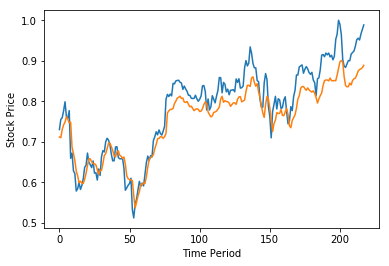

In [8]:
# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")